Plots a histogram to visually communicate temperature anomaly of a day's SST

In [184]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime

In [185]:
def suffix(day):
    updated_day = day
    if updated_day == 1:
        suffix = 'st'
    elif updated_day == 2:
        suffix = 'nd'
    elif updated_day == 3:
        suffix = 'rd'
    elif (4 <= updated_day <= 20):
        suffix = 'th'
    elif updated_day == 21:
        suffix = 'st'
    elif updated_day == 22:
        suffix = 'nd'
    elif updated_day == 23:
        suffix = 'rd'
    elif (24 <= updated_day <= 30):
        suffix = 'th'
    elif updated_day == 31:
        suffix = 'st'
    return suffix

In [186]:
months = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}

In [187]:
c_to_f = lambda c: (c*(9/5)) + 32

In [188]:
def trivia_msg(climatology, today_sst, day, month):
    trivia_msg = None
    obs_datetime = datetime(year=int(2024), month=int(month), day=int(day)).strftime('%b %-d %Y')
    if today_sst > climatology.SURF_TEMP_C.mean():
        trivia_msg = obs_datetime + ' is warmer than  \n the average of all ' + months[month] + ' ' + str(int(day)) + suffix(day) + 's.'
    elif today_sst < climatology.SURF_TEMP_C.mean():
        trivia_msg = obs_datetime + ' is cooler than  \n the average of all ' + months[month] + ' ' + str(int(day)) + suffix(day) + 's.'
    if today_sst > np.nanpercentile(climatology.SURF_TEMP_C.values,90): #How do you define a MHW day? Also np.percentile assumes a normal distribution I think
        trivia_msg = obs_datetime + ' is among the hottest 10% \nof ' + months[month] + ' ' + str(int(day)) + suffix(day) + 's on record.'
    if today_sst < np.nanpercentile(climatology.SURF_TEMP_C.values,10): #How do you define a MHW day? Also np.percentile assumes a normal distribution I think
        trivia_msg = obs_datetime + ' is among the coldest 10% \nof ' + months[month] + ' ' + str(int(day)) + suffix(day) + 's on record.'
    if today_sst >= climatology.SURF_TEMP_C.max():
        trivia_msg = obs_datetime + ' is the hottest \n' + months[month] + ' ' + str(int(day)) + suffix(day) + ' on record.'
    elif today_sst <= climatology.SURF_TEMP_C.min():
        trivia_msg = obs_datetime + ' is the coldest \n' + months[month] + ' ' + str(int(day)) + suffix(day) + ' on record.'
    return trivia_msg

In [189]:
from pathlib import Path
import matplotlib as mpl
fpath = Path(mpl.get_data_path(), "/Users/noahbarton/Library/CloudStorage/OneDrive-UCSanDiego/sccoos/sst_hist/lato/Lato-Regular.ttf")

In [190]:
def sst_hist(sst_filename, location):
    all_sst = pd.read_csv(sst_filename, usecols = ['SURF_TEMP_C','MONTH','DAY','YEAR'])
    last = all_sst.iloc[-1,:]
    day = last.DAY
    month = last.MONTH
    year = last.YEAR
    today_sst = last.SURF_TEMP_C
    today_suffix = suffix(day)
    climatology = all_sst[(all_sst['MONTH'] == month) & (all_sst['DAY'] == day)]
    max_day = all_sst.loc[climatology.SURF_TEMP_C.idxmax()]
    min_day = all_sst.loc[climatology.SURF_TEMP_C.idxmin()]
    mean = climatology.SURF_TEMP_C.mean()
    max_msg = 'Record High SST: '  + str(max_day.SURF_TEMP_C) + '°C in ' + str(int(max_day.YEAR))
    min_msg = 'Record Low SST: '  + str(min_day.SURF_TEMP_C) + '°C in ' + str(int(min_day.YEAR))
    mean_msg = 'Average SST: ' + str(round(mean,1)) + '°C/' + str(round(c_to_f(today_sst), 1)) +'°F'
    n_msg = 'from ' + str(climatology.shape[0]) + ' samples since ' + str(climatology.YEAR.min())
    obs_datetime = datetime(year=int(year), month=int(month), day=int(day))
    cm = plt.colormaps.get_cmap('RdBu_r')
    fig, ax = plt.subplots()

    n, bins, patches = ax.hist(climatology.SURF_TEMP_C, bins = 20, edgecolor='none')
    ax.axvline(today_sst, color='k', linestyle='dashed', linewidth=1)
    ax.axvline(mean, color='k', linestyle='dotted', linewidth=1, c= '#404040')
    ylim = plt.gca().get_ylim()
    top = ylim[1]
    bottom = ylim[0]
    xlim = plt.gca().get_xlim()
    left = xlim[0]
    right = xlim[1]
    y_range = top - bottom

    today_label_x = today_sst + 0.15 if today_sst > mean else today_sst - 0.3
    mean_label_x = mean + 0.15 if today_sst < mean else mean - 0.3
    today_label = obs_datetime.strftime('%b %-d %Y') + " Temperature: " + str(today_sst) + '°C/' + str(round(c_to_f(today_sst), 1)) +'°F'
    avg_label = "Average Temperature of all " + obs_datetime.strftime('%b %-d') + today_suffix +'s'
    ax.text(today_label_x, bottom + 0.4, today_label, rotation =90, font=fpath)
    ax.text(mean_label_x, bottom + 0.4, avg_label, c='#404040', rotation =90, font=fpath)
    plt.xlabel('Temperature (°C)', font=fpath)
    ax.set_xticklabels(ax.get_xticks(), fontproperties=fpath)
    plt.gca().axes.get_yaxis().set_visible(False)
    plt.ylabel('Frequency')
    ax.text(right + 0.1, top - 1, max_msg, fontsize=10, color='#67001F', font = fpath)
    ax.text(right + 0.1, top - 2, min_msg, fontsize=10, color='#053061', font = fpath)
    ax.text(right + 0.1, top - 3, mean_msg, fontsize=10, c='k', font = fpath)
    ax.text(right + 0.1, top - 4, n_msg, fontsize=10, c='k', font = fpath)
    ax.text(right + 0.1, bottom, trivia_msg(climatology, today_sst, day, month), fontsize=10, font = fpath)

    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    col = bin_centers - min(bin_centers)
    col /= max(col)

    for c, p in zip(col, patches):
        plt.setp(p, 'facecolor', cm(c))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    fig_filename = 'test'+".png"
    data_dir = 'ELENA TODO'
    plt.savefig(data_dir+fig_filename, bbox_inches='tight')
    plt.show()

/var/folders/rh/vbg2_t2n7n323x0x6b1lg8c40000gn/T/ipykernel_58968/2254468783.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticks(), fontproperties=fpath)


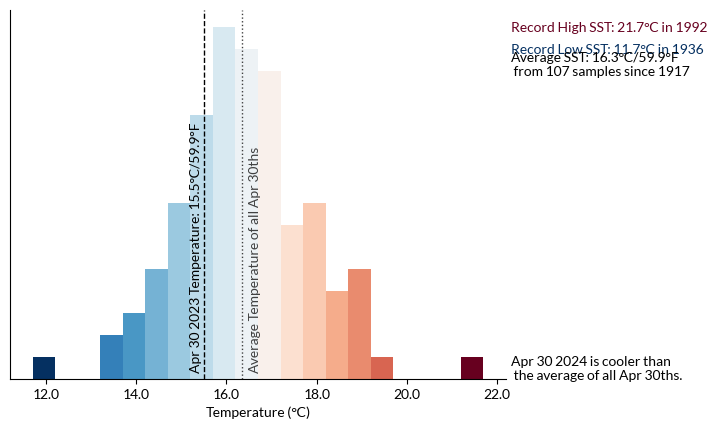

In [191]:
sst_filename='SIO_TEMP_20230105.csv'
location = 'SIO Pier'

sst_hist(sst_filename, location)